## Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [2]:
# Load data
df = pd.read_csv('PFE-Pfizer.csv')

## Data preprocessing

In [3]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-03-01,41.375713,41.546490,41.072105,41.138519,33.767422,26667781
2019-03-04,41.214420,41.356735,40.683113,40.863377,33.541576,22805820
2019-03-05,40.882355,41.034157,40.654648,40.692600,33.401398,26529812
2019-03-06,40.626186,40.673622,39.487667,39.715370,32.599270,22410359
2019-03-07,39.715370,39.743832,39.136623,39.269451,32.233242,29046132
...,...,...,...,...,...,...
2024-02-23,27.750000,28.090000,27.690001,27.760000,27.760000,33182600
2024-02-26,27.670000,27.670000,27.070000,27.180000,27.180000,45685500
2024-02-27,27.120001,27.200001,26.809999,26.889999,26.889999,38598400


## Scale Data

In [4]:
# Select 'Close' column
data = df['Close'].values

In [5]:
# Scale data
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data.reshape(-1, 1))

## Split the data into train and test

In [6]:
# Define the size of train and test
train_size = int(len(data_scaled) * 0.8)
test_size = len(data_scaled) - train_size

# Split the data into train and test set
train_data = data_scaled[0 : train_size, :]
test_data = data_scaled[train_size : len(data_scaled), :]

## Create and add data into X, y

In [7]:
def add_data(data, sequence_length=1):
    X, Y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i : (i + sequence_length), 0])
        Y.append(data[i + sequence_length, 0])
    return np.array(X), np.array(Y)

In [8]:
# Reshape into X=t,t+1,t+2..t+60 and Y=t+60
sequence_length = 60

# Get last data for test
train_last_windowsize = train_data[-sequence_length:]

test_data_extended = np.concatenate((train_last_windowsize, test_data), axis=0)

X_train, y_train = add_data(train_data, sequence_length)
X_test, y_test = add_data(test_data_extended, sequence_length)

# Reshape inputs to [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

## Build Model

In [9]:
model = Sequential() # Encapsulate the sequence of the inner layers

# 4 LSTM layers
model.add(LSTM(units = 50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# 1 Dense layer
model.add(Dense(units=1)) 

# Optimizer
model.compile(optimizer = 'adam', loss='mean_squared_error')

D:\Anaconda\Anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Training Model

In [10]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2)

Epoch 1/50
30/30 - 75s - 2s/step - loss: 0.0377
Epoch 2/50
30/30 - 4s - 120ms/step - loss: 0.0089
Epoch 3/50
30/30 - 5s - 179ms/step - loss: 0.0088
Epoch 4/50
30/30 - 3s - 104ms/step - loss: 0.0080
Epoch 5/50
30/30 - 3s - 114ms/step - loss: 0.0075
Epoch 6/50
30/30 - 5s - 157ms/step - loss: 0.0065
Epoch 7/50
30/30 - 4s - 135ms/step - loss: 0.0065
Epoch 8/50
30/30 - 4s - 118ms/step - loss: 0.0061
Epoch 9/50
30/30 - 4s - 124ms/step - loss: 0.0061
Epoch 10/50
30/30 - 4s - 127ms/step - loss: 0.0057
Epoch 11/50
30/30 - 4s - 125ms/step - loss: 0.0054
Epoch 12/50
30/30 - 3s - 116ms/step - loss: 0.0052
Epoch 13/50
30/30 - 3s - 114ms/step - loss: 0.0048
Epoch 14/50
30/30 - 4s - 144ms/step - loss: 0.0055
Epoch 15/50
30/30 - 5s - 180ms/step - loss: 0.0044
Epoch 16/50
30/30 - 4s - 120ms/step - loss: 0.0048
Epoch 17/50
30/30 - 4s - 118ms/step - loss: 0.0043
Epoch 18/50
30/30 - 6s - 214ms/step - loss: 0.0043
Epoch 19/50
30/30 - 4s - 138ms/step - loss: 0.0041
Epoch 20/50
30/30 - 5s - 165ms/step - loss

## Predict and Inverse Transform the Predictions

In [11]:
y_pred = model.predict(X_test)

# Inverse transform the predictions
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
train_data = scaler.inverse_transform(train_data)
test_data = scaler.inverse_transform(test_data)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step


## Calculate the error of the model

In [12]:
# The error in test set
test_mape = mean_absolute_percentage_error(y_pred, y_test)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(y_test, y_pred)

print(f"MAPE on Test set: ", test_mape)
print(f"RMSE on Test set: ", test_rmse)
print(f"MSLE on Test set: ", test_msle)

MAPE on Test set:  0.020782953735778258
RMSE on Test set:  0.8663155760810776
MSLE on Test set:  0.0006266744233406437


## Predict Close price for 60 next days

In [13]:
# Select the last day of current index
last_date = df.index[-1]

# Add a new day after the last day
next_date = last_date + pd.DateOffset(days=1)

# Generate a list of index only starting from the next day in 60 days
index_next_60_days = pd.date_range(start=next_date, periods=60).tolist()

# Predict Close price for 60 next days
last_sequence_days = data_scaled[-sequence_length:].reshape(1, -1, 1)

y_next_60_days = []

for i in range(60):
    # Predict Close price for next day
    next_day_pred = model.predict(last_sequence_days)
    
    # Save the predict value
    y_next_60_days.append(next_day_pred[0][0])
    
    # Update information of the next day
    last_sequence_days = np.concatenate([last_sequence_days[:, 1:, :], next_day_pred.reshape(1, 1, 1)], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━

In [14]:
# Show the result of predict 60 next days 
y_next_60_days = scaler.inverse_transform(np.array(y_next_60_days).reshape(-1, 1))
print(y_next_60_days.flatten())

[27.441929 27.289858 27.169147 27.097054 27.069897 27.073904 27.09453
 27.121304 27.148836 27.175495 27.201668 27.22832  27.256142 27.285362
 27.31573  27.346802 27.378078 27.409126 27.4396   27.469265 27.497921
 27.525463 27.551805 27.576845 27.600529 27.622822 27.643713 27.663202
 27.681282 27.698006 27.713406 27.727537 27.740456 27.752228 27.762924
 27.772621 27.78141  27.789343 27.796495 27.802952 27.80877  27.81401
 27.818756 27.823063 27.826958 27.830513 27.833776 27.836786 27.83958
 27.842207 27.84468  27.847017 27.849257 27.851412 27.853498 27.855537
 27.85753  27.8595   27.86145  27.863373]


## Model visualization

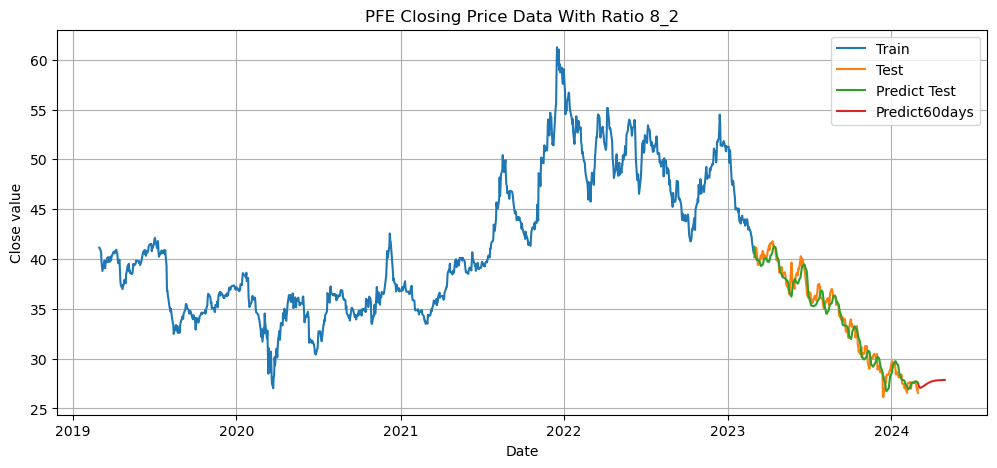

In [15]:
plt.figure(figsize=(12, 5))

# Train set
plt.plot(df[:train_size].index, train_data)

# Test set
plt.plot(df[train_size:].index, test_data)

# Predict in test set
plt.plot(df[train_size:].index, y_pred)

# Predict 60 next days
plt.plot(index_next_60_days, y_next_60_days)

plt.legend(['Train', 'Test', 'Predict Test', 'Predict60days'])
plt.grid()
plt.title("PFE Closing Price Data With Ratio 8_2")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('Image/RNN_82_60days_PFE.png')
plt.show()